# NCAR Innovator Program Project
### Notebook by: Maria J. Molina (NCAR/University of Maryland) and Jessica Moulite (Howard University)

Here we compare the NOAA BWI weather station temperature (Baltimore Washington International Airport) data with 2-m temperature data from ERA5. The objective of the comparison is to assess how representative state-of-the-art reanalysis is of local weather and trends, given its heavy use in climate assessment studies.

Importing packages

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

Functions

In [2]:
def cel_to_far(tmp):
    """
    Convert celsius to farenheit
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append((i * (9/5)) + 32)
    return np.array(newtmp)


def cel_to_nan(tmp):
    """
    Change 9999 to np.nan
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append(i)
    return np.array(newtmp)


def convert_to_datetime(time_value):
    """
    Convert to a datetime object to be able to compute time difference.
    """
    return datetime.datetime(
        pd.to_datetime(time_value).year,
        pd.to_datetime(time_value).month,
        pd.to_datetime(time_value).day,
        pd.to_datetime(time_value).hour,
        pd.to_datetime(time_value).minute,
        pd.to_datetime(time_value).second,
    )


def compute_time_difference(a, b):
    """
    Compute time difference between two times.
    """
    if a >= b:
        return convert_to_datetime(a) - convert_to_datetime(b)
    if b > a:
        return convert_to_datetime(b) - convert_to_datetime(a)


def extract_era5_time(t_daily, t_full):
    """
    Extract the era5 temperature corresponding time.
    """
    era5_time_array = []

    for i, j in zip(t_daily.time, t_daily):

        tmp = t_full.sel(
            time=slice(i, pd.to_datetime(i.values) + datetime.timedelta(hours=23)))

        era5_time_array.append(tmp.where(tmp == j, drop=True).time.values)

    return era5_time_array

## Open ERA5 data (1973-present)

In [3]:
# open files
ds_ = xr.open_mfdataset(
    '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.sfc/*/e5.oper.an.sfc.128_167_2t.ll025sc.*.nc')['VAR_2T']

In [4]:
ds_

<xarray.DataArray 'VAR_2T' (time: 482136, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(482136, 721, 1440), dtype=float32, chunksize=(744, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1967-06-01 ... 2022-05-31T23:00:00
Attributes: (12/14)
    long_name:                                          2 metre temperature
    short_name:                                         2t
    units:                                              K
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

## Open NOAA BWI station data

In [7]:
BWI_temp = pd.read_csv('/glade/scratch/molina/3043179.csv', low_memory=False)

In [8]:
# subset the data using dates of interest (what is available in ERA5)
BWI_temp = BWI_temp[(
    BWI_temp['DATE'] >= str(
        pd.to_datetime(ds_.coords['time'].isel(time=0).values))) & (
    BWI_temp['DATE'] <= str(
        pd.to_datetime(ds_.coords['time'].isel(time=-1).values)))]

Clean up data from NOAA KMIA

In [9]:
time_date = []
temperature_C = []

for j, i in zip(BWI_temp['DATE'].values, BWI_temp['TMP'].values.astype(str)):

    time_date.append(j)

    # convert the string format to decimal format (originally in METAR code)
    temperature_C.append(float(i.split(',')[0][2:-1]+'.'+i.split(',')[0][-1]))

time_date = np.array(time_date)
temperature_C = np.array(temperature_C)

temperature_F = cel_to_far(temperature_C)
temperature_C = cel_to_nan(temperature_C)

In [10]:
# making into dataframe for easier manipulation

# initialize data of lists.
data = {'Datetime': pd.to_datetime(time_date),
        'Temperature_C': temperature_C,
        'Temperature_F': temperature_F,
        'Latitude': BWI_temp['LATITUDE'],
        'Longitude': BWI_temp['LONGITUDE'],
       }

# Create DataFrame and quality control
df = pd.DataFrame(data)
df = df.dropna()  # drop any nan values
df = df.drop_duplicates(keep='first')
# drop any duplicate rows
df = df[~df['Datetime'].duplicated()].drop_duplicates()

In [11]:
df

,Datetime,Temperature_C,Temperature_F,Latitude,Longitude
175252,1973-01-01 06:00:00,17.2,62.96,39.17330,-76.68400
175253,1973-01-01 09:00:00,16.7,62.06,39.17330,-76.68400
175254,1973-01-01 12:00:00,13.3,55.94,39.17330,-76.68400
175255,1973-01-01 15:00:00,13.3,55.94,39.17330,-76.68400
175256,1973-01-01 18:00:00,15.0,59.00,39.17330,-76.68400
...,...,...,...,...,...
761284,2022-05-30 19:54:00,32.8,91.04,39.17329,-76.68408
761285,2022-05-30 20:54:00,32.8,91.04,39.17329,-76.68408
761286,2022-05-30 21:54:00,31.1,87.98,39.17329,-76.68408
761287,2022-05-30 22:54:00,30.0,86.00,39.17329,-76.68408


## Select temperatures from ERA5 using NOAA BWI metadata (lat, lon, and hour)

In [12]:
ERA5_temperatures_C = []
ERA5_date = []

for lat, lon, date in zip(df['Latitude'], df['Longitude'] % 360, df['Datetime']):

    tmp = ds_.sel(longitude=lon, latitude=lat, time=date, method='nearest')

    ERA5_temperatures_C.append((tmp - 273.15).values)

    ERA5_date.append(tmp.coords['time'].values)

In [13]:
ERA5_temperatures_C = np.array(ERA5_temperatures_C)

In [14]:
ERA5_temperatures_F = cel_to_far(ERA5_temperatures_C)

In [15]:
# initialize data of lists.
data = {'Datetime': pd.to_datetime(ERA5_date),
        'Temperature_C': ERA5_temperatures_C,
        'Temperature_F': ERA5_temperatures_F,
       }

df_era5 = pd.DataFrame(data)

In [16]:
# drop duplicate rows
df = df[~df_era5['Datetime'].duplicated().values]
df_era5 = df_era5[~df_era5['Datetime'].duplicated()].drop_duplicates()

## Create new variables

### Daily max and min temperatures

In [17]:
# Daily NOAA BWI temperature maximum
tmax_NOAA_daily = df.set_index('Datetime').resample('1D').max()

In [18]:
# Daily ERA5 temperature maximum
tmax_ERA5_daily = df_era5.set_index('Datetime').resample('1D').max()

In [19]:
# Daily NOAA BWI temperature minimum
tmin_NOAA_daily = df.set_index('Datetime').resample('1D').min()

In [20]:
# Daily ERA5 temperature minimum
tmin_ERA5_daily = df_era5.set_index('Datetime').resample('1D').min()

### Time of daily max and min temperatures

In [21]:
# corresponding date/time for NOAA BWI daily temperature maximum
tmax_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmax()
)['Temperature_C']

In [22]:
# corresponding date/time for NOAA BWI daily temperature minimum
tmin_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmin()
)['Temperature_C']

In [23]:
# corresponding date/time for ERA5 daily temperature maximum
tmax_ERA5_daily_datetime = df_era5.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmax()
)['Temperature_C']

In [24]:
# corresponding date/time for ERA5 daily temperature minimum
tmin_ERA5_daily_datetime = df_era5.set_index('Datetime').resample('1D').agg(
    lambda x: np.nan if x.count() == 0 else x.idxmin()
)['Temperature_C']

### Corresponding temperatures at the time of the max/min of other product

In [25]:
# the NOAA temperature during the (i.e., same time as the
# daily ERA5 maximum temperature)

NOAA_temp_during_ERA5_tmax_C = []
NOAA_temp_during_ERA5_tmax_F = []

for i in tmax_ERA5_daily_datetime.values:

    NOAA_temp_during_ERA5_tmax_C.append(
        df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_C'])

    NOAA_temp_during_ERA5_tmax_F.append(
        df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_F'])

NOAA_temp_during_ERA5_tmax_C = np.array(NOAA_temp_during_ERA5_tmax_C)
NOAA_temp_during_ERA5_tmax_F = np.array(NOAA_temp_during_ERA5_tmax_F)

In [26]:
# the NOAA temperature during the (i.e., same time as the
# daily ERA5 minimum temperature)

NOAA_temp_during_ERA5_tmin_C = []
NOAA_temp_during_ERA5_tmin_F = []

for i in tmin_ERA5_daily_datetime.values:

    NOAA_temp_during_ERA5_tmin_C.append(
        df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_C'])

    NOAA_temp_during_ERA5_tmin_F.append(
        df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_F'])

NOAA_temp_during_ERA5_tmin_C = np.array(NOAA_temp_during_ERA5_tmin_C)
NOAA_temp_during_ERA5_tmin_F = np.array(NOAA_temp_during_ERA5_tmin_F)

In [27]:
# the ERA5 temperature during the (i.e., same time as the
# daily NOAA BWI maximum temperature)

ERA5_temp_during_NOAA_tmax_C = []
ERA5_temp_during_NOAA_tmax_F = []

for i in tmax_NOAA_daily_datetime.values:

    ERA5_temp_during_NOAA_tmax_C.append(
        df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
            i, method='nearest')]['Temperature_C'])

    ERA5_temp_during_NOAA_tmax_F.append(
        df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
            i, method='nearest')]['Temperature_F'])

ERA5_temp_during_NOAA_tmax_C = np.array(ERA5_temp_during_NOAA_tmax_C)
ERA5_temp_during_NOAA_tmax_F = np.array(ERA5_temp_during_NOAA_tmax_F)

In [28]:
# the ERA5 temperature during the (i.e., same time as the
# daily NOAA BWI minimum temperature)

ERA5_temp_during_NOAA_tmin_C = []
ERA5_temp_during_NOAA_tmin_F = []

for i in tmin_NOAA_daily_datetime.values:

    ERA5_temp_during_NOAA_tmin_C.append(
        df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
            i, method='nearest')]['Temperature_C'])

    ERA5_temp_during_NOAA_tmin_F.append(
        df_era5.iloc[df_era5.set_index('Datetime').index.get_loc(
            i, method='nearest')]['Temperature_F'])

ERA5_temp_during_NOAA_tmin_C = np.array(ERA5_temp_during_NOAA_tmin_C)
ERA5_temp_during_NOAA_tmin_F = np.array(ERA5_temp_during_NOAA_tmin_F)

### differences (temperature)

In [29]:
# difference between NOAA BWI temperature maximum and
# the ERA5 corresponding temperature at that time (C)
tmax_daily_difference_C = tmax_NOAA_daily['Temperature_C'] - ERA5_temp_during_NOAA_tmax_C

In [30]:
# difference between NOAA BWI temperature maximum and
# the ERA5 corresponding temperature at that time (F)
tmax_daily_difference_F = tmax_NOAA_daily['Temperature_F'] - ERA5_temp_during_NOAA_tmax_F

In [31]:
# difference between NOAA BWI temperature minimum and
# the ERA5 corresponding temperature at that time (C)
tmin_daily_difference_C = tmin_NOAA_daily['Temperature_C'] - ERA5_temp_during_NOAA_tmin_C

In [32]:
# difference between NOAA BWI temperature minimum and
# the ERA5 corresponding temperature at that time (C)
tmin_daily_difference_F = tmin_NOAA_daily['Temperature_F'] - ERA5_temp_during_NOAA_tmin_F

### compute time differences

In [33]:
# absolute time difference between daily maximum temperature (ERA5 and NOAA)
tmax_diff = []
for i, j in zip(pd.to_datetime(tmax_NOAA_daily_datetime), tmax_ERA5_daily_datetime[:-1]):
    tmax_diff.append(compute_time_difference(i, j))
tmax_diff = np.array(tmax_diff)

In [34]:
# absolute time difference between daily minimum temperature (ERA5 and NOAA)
tmin_diff = []
for i, j in zip(pd.to_datetime(tmin_NOAA_daily_datetime), tmin_ERA5_daily_datetime[:-1]):
    tmin_diff.append(compute_time_difference(i, j))
tmin_diff = np.array(tmin_diff)

### create single csv file

In [37]:
data = {

    'NOAA_BWI_Temperature_Daily_Max (C)': tmax_NOAA_daily['Temperature_C'],
    'NOAA_BWI_Temperature_Daily_Max (F)': tmax_NOAA_daily['Temperature_F'],
    'NOAA_BWI_Temperature_Daily_Max_Datetime': tmax_NOAA_daily_datetime,

    'NOAA_BWI_Temperature_Daily_Min (C)': tmin_NOAA_daily['Temperature_C'],
    'NOAA_BWI_Temperature_Daily_Min (F)': tmin_NOAA_daily['Temperature_F'],
    'NOAA_BWI_Temperature_Daily_Min_Datetime': tmin_NOAA_daily_datetime,

    'ERA5_Temperature_Daily_Max (C)': tmax_ERA5_daily['Temperature_C'][:-1],
    'ERA5_Temperature_Daily_Max (F)': tmax_ERA5_daily['Temperature_F'][:-1],
    'ERA5_Temperature_Daily_Max_Datetime': tmax_ERA5_daily_datetime[:-1],

    'ERA5_Temperature_Daily_Min (C)': tmin_ERA5_daily['Temperature_C'][:-1],
    'ERA5_Temperature_Daily_Min (F)': tmin_ERA5_daily['Temperature_F'][:-1],
    'ERA5_Temperature_Daily_Min_Datetime': tmin_ERA5_daily_datetime[:-1],


    'ERA5_Corresponding_Temperature_During_NOAA_BWI_Daily_Max (C)': ERA5_temp_during_NOAA_tmax_C,
    'ERA5_Corresponding_Temperature_During_NOAA_BWI_Daily_Max (F)': ERA5_temp_during_NOAA_tmax_F,

    'ERA5_Corresponding_Temperature_During_NOAA_BWI_Daily_Min (C)': ERA5_temp_during_NOAA_tmin_C,
    'ERA5_Corresponding_Temperature_During_NOAA_BWI_Daily_Min (F)': ERA5_temp_during_NOAA_tmin_F,

    'NOAA_BWI_Corresponding_Temperature_During_ERA5_Daily_Max (C)': NOAA_temp_during_ERA5_tmax_C[:-1],
    'NOAA_BWI_Corresponding_Temperature_During_ERA5_Daily_Max (F)': NOAA_temp_during_ERA5_tmax_F[:-1],

    'NOAA_BWI_Corresponding_Temperature_During_ERA5_Daily_Min (C)': NOAA_temp_during_ERA5_tmin_C[:-1],
    'NOAA_BWI_Corresponding_Temperature_During_ERA5_Daily_Min (F)': NOAA_temp_during_ERA5_tmin_F[:-1],


    'Daily_Temperature_Max_Difference (C)': tmax_daily_difference_C.values,
    'Daily_Temperature_Max_Difference (F)': tmax_daily_difference_F.values,

    'Daily_Temperature_Min_Difference (C)': tmin_daily_difference_C.values,
    'Daily_Temperature_Min_Difference (F)': tmin_daily_difference_F.values,

    'Absolute_time_difference_tmax_ERA5_NOAA_BWI (day H:M:S)': tmax_diff,
    'Absolute_time_difference_tmin_ERA5_NOAA_BWI (day H:M:S)': tmin_diff,

       }

In [38]:
df_FINAL = pd.DataFrame(data)

In [39]:
df_FINAL

,NOAA_BWI_Temperature_Daily_Max (C),NOAA_BWI_Temperature_Daily_Max (F),NOAA_BWI_Temperature_Daily_Max_Datetime,NOAA_BWI_Temperature_Daily_Min (C),NOAA_BWI_Temperature_Daily_Min (F),NOAA_BWI_Temperature_Daily_Min_Datetime,ERA5_Temperature_Daily_Max (C),ERA5_Temperature_Daily_Max (F),ERA5_Temperature_Daily_Max_Datetime,ERA5_Temperature_Daily_Min (C),...,NOAA_BWI_Corresponding_Temperature_During_ERA5_Daily_Max (C),NOAA_BWI_Corresponding_Temperature_During_ERA5_Daily_Max (F),NOAA_BWI_Corresponding_Temperature_During_ERA5_Daily_Min (C),NOAA_BWI_Corresponding_Temperature_During_ERA5_Daily_Min (F),Daily_Temperature_Max_Difference (C),Daily_Temperature_Max_Difference (F),Daily_Temperature_Min_Difference (C),Daily_Temperature_Min_Difference (F),Absolute_time_difference_tmax_ERA5_NOAA_BWI (day H:M:S),Absolute_time_difference_tmin_ERA5_NOAA_BWI (day H:M:S)
Datetime,,,,,,,,,,,,,,,,,,,,,
1973-01-01,17.2,62.96,1973-01-01 06:00:00,13.3,55.94,1973-01-01 12:00:00,16.474207,61.653572,1973-01-01 06:00:00,12.062006,...,17.2,62.96,13.3,55.94,0.725793,1.306428,1.237994,2.228389,0 days 00:00:00,0 days 00:00:00
1973-01-02,7.8,46.04,1973-01-02 00:00:00,4.4,39.92,1973-01-02 12:00:00,8.573328,47.431990,1973-01-02 00:00:00,3.737268,...,7.8,46.04,4.4,39.92,-0.773328,-1.391990,0.662732,1.192918,0 days 00:00:00,0 days 00:00:00
1973-01-03,4.4,39.92,1973-01-03 09:00:00,1.1,33.98,1973-01-03 03:00:00,1.960626,35.529127,1973-01-03 21:00:00,-3.762335,...,2.2,35.96,4.4,39.92,8.162335,14.692204,2.216461,3.989630,0 days 12:00:00,0 days 06:00:00
1973-01-04,8.9,48.02,1973-01-04 21:00:00,0.6,33.08,1973-01-04 03:00:00,8.872705,47.970870,1973-01-04 21:00:00,1.663171,...,8.9,48.02,1.7,35.06,0.027295,0.049130,-1.149414,-2.068945,0 days 00:00:00,0 days 03:00:00
1973-01-05,7.2,44.96,1973-01-05 03:00:00,3.3,37.94,1973-01-05 12:00:00,6.104364,42.987855,1973-01-05 00:00:00,3.292749,...,4.4,39.92,3.3,37.94,1.985071,3.573128,0.007251,0.013052,0 days 03:00:00,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26,22.8,73.04,2022-05-26 19:54:00,15.6,60.08,2022-05-26 07:54:00,20.845789,69.522420,2022-05-26 22:00:00,14.946680,...,22.2,71.96,15.6,60.08,2.576587,4.637856,0.167419,0.301354,0 days 02:06:00,0 days 01:06:00
2022-05-27,25.6,78.08,2022-05-27 16:36:00,20.0,68.00,2022-05-27 02:35:00,23.203577,73.766439,2022-05-27 18:00:00,18.876520,...,20.6,69.08,20.0,68.00,2.854309,5.137756,0.392675,0.706816,0 days 01:24:00,0 days 03:25:00
2022-05-28,26.1,78.98,2022-05-28 19:54:00,17.2,62.96,2022-05-28 09:54:00,24.657373,76.383272,2022-05-28 22:00:00,17.793299,...,24.4,75.92,17.8,64.04,2.142181,3.855926,-0.728370,-1.311065,0 days 02:06:00,0 days 00:54:00


### data visualizations

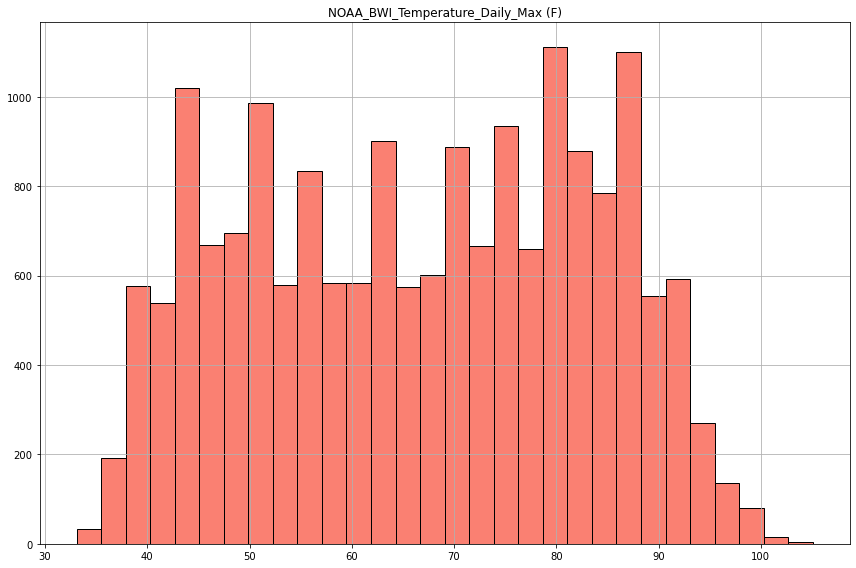

In [40]:
fig = df_FINAL.hist(
    'NOAA_BWI_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
# plt.savefig('/Users/molina/Desktop/ShadingDade_Temperature_Daily_Max.png', dpi=500)
plt.show()

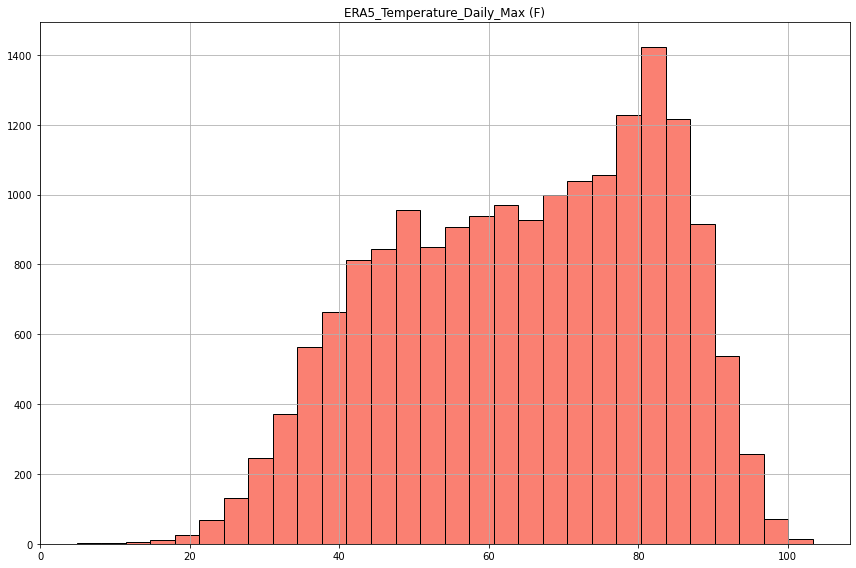

In [41]:
fig = df_FINAL.hist(
    'ERA5_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
# plt.savefig('/Users/molina/Desktop/ShadingDade_Temperature_Daily_Max.png', dpi=500)
plt.show()

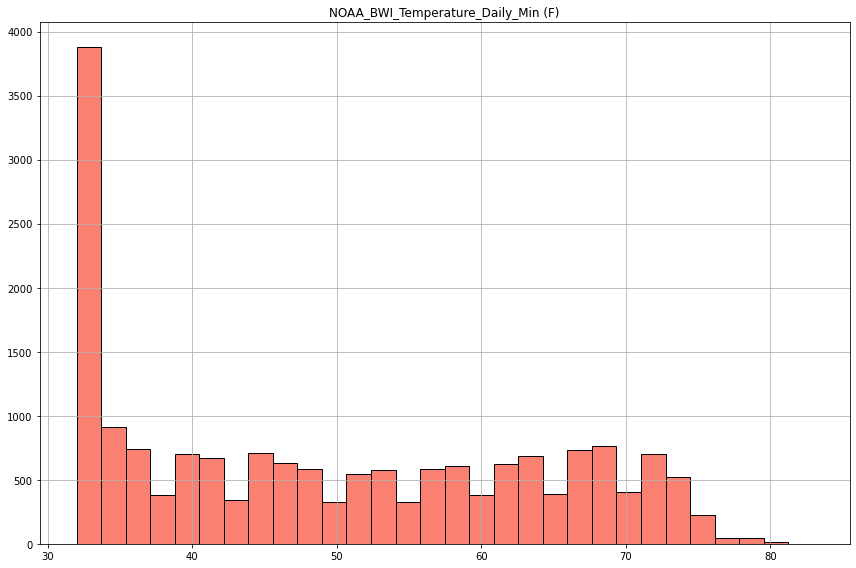

In [42]:
fig = df_FINAL.hist(
    'NOAA_BWI_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
# plt.savefig('/Users/molina/Desktop/ShadingDade_Temperature_Daily_Max.png', dpi=500)
plt.show()

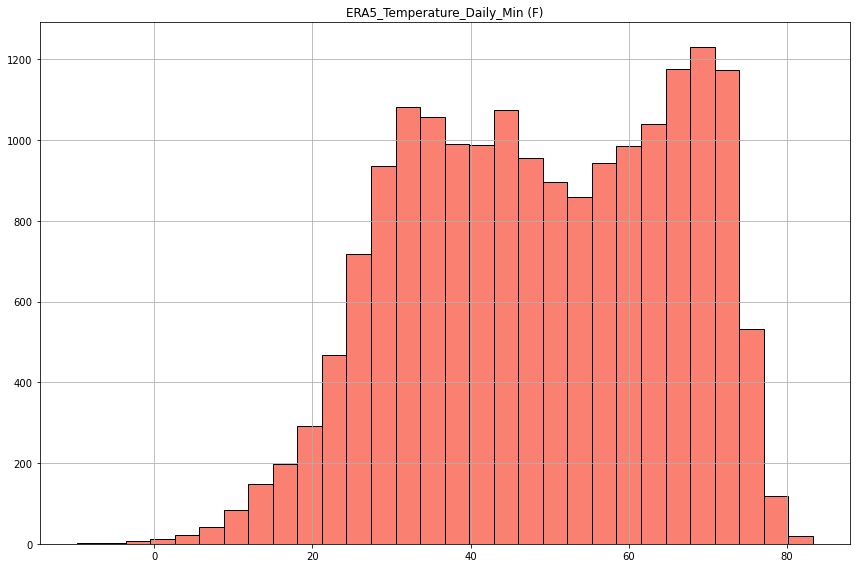

In [43]:
fig = df_FINAL.hist(
    'ERA5_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
# plt.savefig('/Users/molina/Desktop/ShadingDade_Temperature_Daily_Max.png', dpi=500)
plt.show()

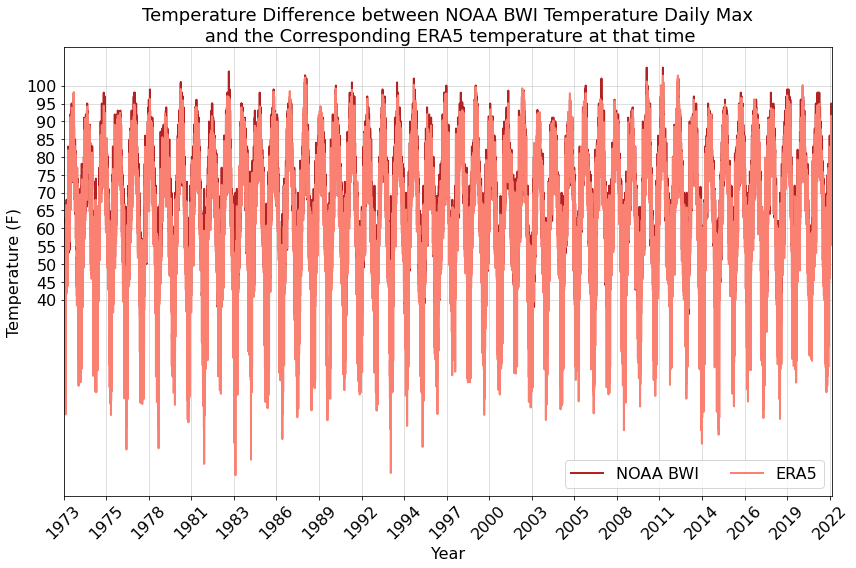

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title(
    'Temperature Difference between NOAA BWI Temperature Daily Max\n and the Corresponding ERA5 temperature at that time', 
    fontsize=18)

ls0, = ax.plot(df_FINAL['NOAA_BWI_Temperature_Daily_Max (F)'].values, color='firebrick', lw=2.0)
ls1, = ax.plot(df_FINAL['ERA5_Corresponding_Temperature_During_NOAA_BWI_Daily_Max (F)'].values, color='salmon', lw=2.0)

ax.legend([ls0, ls1], ['NOAA BWI', 'ERA5'],
          fancybox=True, fontsize=16, ncol=2)

ax.set_xticks(np.arange(0, df_FINAL['ERA5_Corresponding_Temperature_During_NOAA_BWI_Daily_Max (F)'].values.shape[0])[::1000])
ax.set_xticklabels(pd.to_datetime(tmax_NOAA_daily_datetime).dt.year[::1000],
                   rotation=45, fontsize=16)
ax.set_xlabel('Year', fontsize=16)

ax.set_yticks(np.arange(40,101,1)[::5])
ax.set_yticklabels(np.arange(40,101,1)[::5], fontsize=16)
ax.set_ylabel('Temperature (F)', fontsize=16)

ax.grid('--', alpha=0.5)
ax.margins(x=0)

plt.tight_layout()
# plt.savefig('/Users/molina/Desktop/TempDiff_SDandERA5.png', dpi=500)
plt.show()

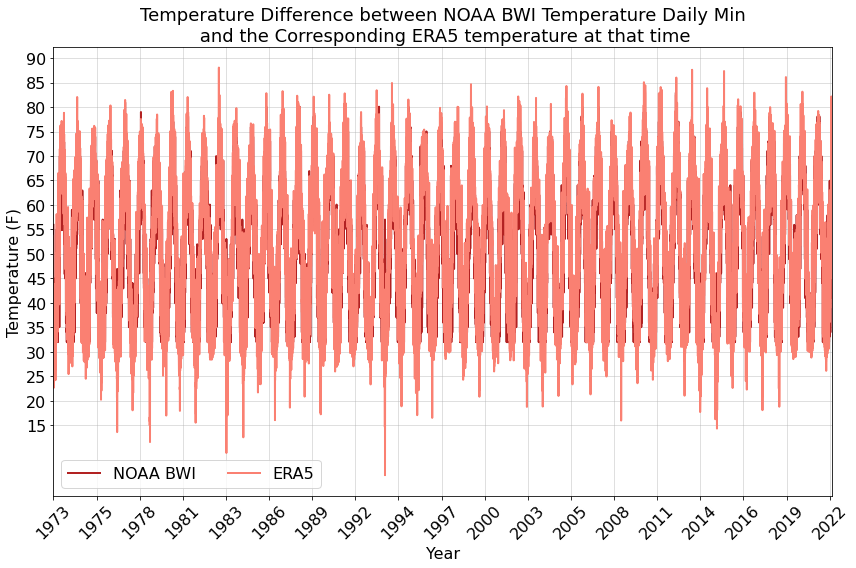

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title(
    'Temperature Difference between NOAA BWI Temperature Daily Min\n and the Corresponding ERA5 temperature at that time', 
    fontsize=18)

ls0, = ax.plot(df_FINAL['NOAA_BWI_Temperature_Daily_Min (F)'].values, color='firebrick', lw=2.0)
ls1, = ax.plot(df_FINAL['ERA5_Corresponding_Temperature_During_NOAA_BWI_Daily_Min (F)'].values, color='salmon', lw=2.0)

ax.legend([ls0, ls1], ['NOAA BWI', 'ERA5'],
          fancybox=True, fontsize=16, ncol=2)

ax.set_xticks(np.arange(0, df_FINAL['ERA5_Corresponding_Temperature_During_NOAA_BWI_Daily_Min (F)'].values.shape[0])[::1000])
ax.set_xticklabels(pd.to_datetime(tmax_NOAA_daily_datetime).dt.year[::1000],
                   rotation=45, fontsize=16)
ax.set_xlabel('Year', fontsize=16)

ax.set_yticks(np.arange(15,91,1)[::5])
ax.set_yticklabels(np.arange(15,91,1)[::5], fontsize=16)
ax.set_ylabel('Temperature (F)', fontsize=16)

ax.grid('--', alpha=0.5)
ax.margins(x=0)

plt.tight_layout()
# plt.savefig('/Users/molina/Desktop/TempDiff_SDandERA5.png', dpi=500)
plt.show()

## save csv file

In [50]:
df_FINAL.to_csv(
    '/glade/scratch/molina/NOAA_BWI_ERA5_Temperature_1973-2022.csv')